## Imports
These are the same imports as in the origional work notebook.

In [1]:
import matplotlib
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
import copy as cp
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import folium

## Focused fields
We're only going to be looking at these fields, for the same reason listed in the previous work document

In [2]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date'] #text
business_fields = ['business_id', 'name', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'state'] #categories
user_fields = ['user_id', 'name', 'review_count', 'average_stars']

## Create Dataframes

In [3]:
business_df = pd.read_csv("yelp_business.csv", usecols=business_fields)
hours_df = pd.read_csv("yelp_business_hours.csv")
review_chunks = pd.read_csv("yelp_review.csv",usecols=review_fields,chunksize=500000)
users = pd.read_csv("yelp_user.csv", usecols=user_fields, chunksize=500000)

## Sampleable
The sampleable class allows us to easily sample from the dataframes above. This is needed because the files we read in as chunks are read in as a `TextFileReader` object :( this allows us to use everything easily, and take samples effectively

In [4]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        self.sample.dropna()
        self.sample_size = 0
            
    def __mutate(self, sample): # Will always return the next chunk
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getRandomSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def getOrderedSample(self, n_samples):
        return self.sample.head(n_samples)
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
hoursSampler = Sampleable(hours_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)

## Get sampling DataFrames

In [5]:
b_samp = businessSampler.getRandomSample(50000)
h_samp = hoursSampler.getRandomSample(50000)
r_samp = reviewSampler.getRandomSample(50000)
u_samp = userSampler.getRandomSample(50000)

## Random vs. Ordered & How to use Sampleable
The random sampling method will **always** generate a new random sample (without replacement) and store return it as a dataframe. Ordered sample will take the first `n` rows from the top of the dataframe down. It's important to know that if all of the dataframes may not neccesarily line up if you are constantly refreshing the sample. 

Noting that, it's important that if you're going ot merge a DataFrame on an attribute that you are taking a large enough sample (I've noticed that 10,000 is usually pretty good) to merge on the dataframe.

Similarily, it's important to note that these tables are necessarily lined up anyway. What I mean, is that when unless you're loading the majority of the businesses, you're likely unable to get a stable sample when merging two dataframes on an attribute.

If however, you need a normal sample, i.e the first `n` rows, taking an ordered sample will do that! 

In [6]:
b_samp_ordered = businessSampler.getOrderedSample(50000)
h_samp_ordered = hoursSampler.getOrderedSample(50000)
r_samp_ordered = reviewSampler.getOrderedSample(50000)
u_samp_ordered = userSampler.getOrderedSample(50000)

## Exceptions
To handle the exceptions that arise in the wrappers and utility functions

In [7]:
class MergeException(Exception):
    def __init__(message):
        super().__init__(message)

## Some Utility Functions
These are purley for making our lives a little easier.

## MergeWrapper
Merges two dataframes on a specified attribute

In [8]:
def mergeWrapper(df1, df2, attribute):
    if(not isinstance(df1, pd.core.frame.DataFrame) or not isinstance(df2, pd.core.frame.DataFrame)):
        raise MergeException("Arguments: DataFrame, DataFrame, String")
    if(not isinstance(attribute, str)):
        raise MergeException("Merging attribute must be a string")
    if(not attribute in df1 or not attribute in df2):
        raise MergeException("Couldn't find attribute {} in both dataframes!".format(attribute))
    if(not len(df1) == len(df2)):
        raise MergeException("Please make sure DataFrames are the same size!")
    df_final = pd.merge(df1.dropna(), df2.dropna(), on=attribute)
    return df_final

def createClusterData(*args):
    z = zip(*args)
    X = []
    for item in z:
        X.append(item)
    return X
        
def cluster(data, n_clusters, labels=False):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    if(labels):
        return (centroids, kmeans.labels_)
    return centroids

def densityWrapper(x,y):
    xy = np.vstack([x,y])
    z = sc.gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

## Graphing Object
The purpose of the graphing object is to store information about the graph such as the title, x and y labels, primary, secondary and tertiary colors.

In [9]:
class GraphInfo:
    def __init__(self, title, x_vars, y_vars,z_vars=(None, 'None')):
        self.title = title
        if(not isinstance(x_vars, tuple) or not isinstance(y_vars, tuple)):
            raise TypeError("X and Y vars should be tuples (value, name)")
        self.xvalue, self.yvalue, self.zvalue = x_vars[0], y_vars[0], z_vars[0]
        self.xlabel, self.ylabel, self.zlabel = x_vars[1], y_vars[1], z_vars[1]
        self.colors = ['Orange','Grey','Purple'] 
    def getTitle(self):
        return self.title
    def getLabel(self, label_name):
        if(label_name == 'x'):
            return self.xlabel
        elif(label_name == 'y'):
            return self.ylabel
        else:
            return self.zlabel
    def getColor(self, index):
        if(index >= len(self.colors)):
            return 'Black'
        return self.colors[index]

# Let's get to some DataMining

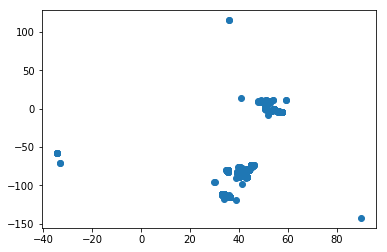

In [10]:
plt.scatter(b_samp['latitude'], b_samp['longitude'])
plt.title("")
plt.show()

In [11]:
focused_sample = b_samp[(b_samp['longitude'] < -50) & (b_samp['latitude'] <= 60) & (b_samp['latitude']>=0)]
print(len(focused_sample))

47731


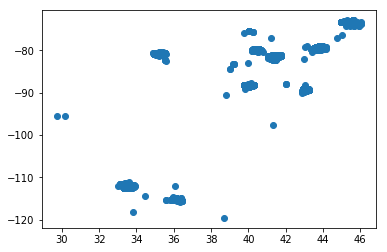

,business_id,name,state,latitude,longitude,stars,review_count,is_open
135720,3QkQn6cndUvCjs1fZLoNYQ,"""IPub""",NC,35.446311,-80.879689,4.5,3,0
165965,u6nZOYK-LhOKFIuoizQEvg,"""Ctown Crossfit West""",OH,41.441055,-81.863896,5.0,6,1
20835,tCCDNdsVMgAXZ_BSFc0FTw,"""Roll & Thai""",ON,43.599049,-79.513736,3.0,10,1
100512,AjlfsNaBsgoT26n_ZkgSew,"""Flora Couture Boutique""",NV,36.115798,-115.299657,4.5,11,1
63307,44YFU284Z3KDEy25QyVoUw,"""Nee House Chinese Restaurant""",AZ,33.613020,-111.977036,3.5,219,1


In [12]:
plt.scatter(focused_sample['latitude'], focused_sample['longitude'])
plt.show()
focused_sample.head()

In [20]:
data = focused_sample.reset_index().head(1000)
# Make an empty map
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
 
#I can add marker one by one on the map
for i in range(0,len(data)):
    s = "{} ({})\nReview Count: {}".format(data.iloc[i]['name'].strip("\"").replace("'", ""),data.iloc[i]['stars'],data.iloc[i]['review_count'])
    folium.Marker([data.iloc[i]['latitude'], data.iloc[i]['longitude']], popup=s).add_to(m)


In [21]:
X = createClusterData(data['latitude'], data['longitude'])
centroids,labels = cluster(X, 15, True)

In [22]:
#m.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker="x", s=100)

for i in range(0, len(centroids)):
    folium.Circle(
          location=[centroids[i][0], centroids[i][1]],
          radius=10000,
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
m.save('map.html')

In [302]:
b_samp1 = b_samp[['state']]
states = b_samp1.stack().unique()
states_counts = {}
for item in states:
    states_counts[item] = 0
print(states_counts)
del states_counts['30']
del states_counts['01']
del states_counts['6']

{'AZ': 0, 'EDH': 0, 'ON': 0, 'NV': 0, 'QC': 0, 'PA': 0, 'OH': 0, 'CHE': 0, 'WI': 0, 'SC': 0, 'NC': 0, 'IL': 0, 'BW': 0, 'FIF': 0, 'GLG': 0, 'NYK': 0, 'HLD': 0, 'MLN': 0, 'AK': 0, 'C': 0, 'AL': 0, 'WLN': 0, 'ESX': 0, 'XGL': 0, 'VS': 0, 'NI': 0, 'ELN': 0, '01': 0, 'ZET': 0, 'CMA': 0, 'ABE': 0, '30': 0, 'MT': 0, 'WHT': 0, 'ST': 0, 'CA': 0, 'GA': 0, 'NY': 0, 'CO': 0, 'SL': 0, 'TAM': 0, 'NE': 0, 'HU': 0, 'RCC': 0, 'FLN': 0, '6': 0, 'VT': 0}


In [322]:
avgs = {}
sums = {}
for item in states_counts.keys():
    avgs[item] = b_samp[b_samp1['state'] == item]['stars'].mean()
    sums[item] = b_samp[b_samp1['state'] == item]['review_count'].sum()
d = pd.DataFrame(list(avgs.items()), columns=['state','stars'])
dd = pd.DataFrame(list(sums.items()), columns=['state','review_count'])
d.head()
dd.head()

,state,review_count
0,AZ,454822
1,EDH,12564
2,ON,178717
3,NV,570037
4,QC,39876


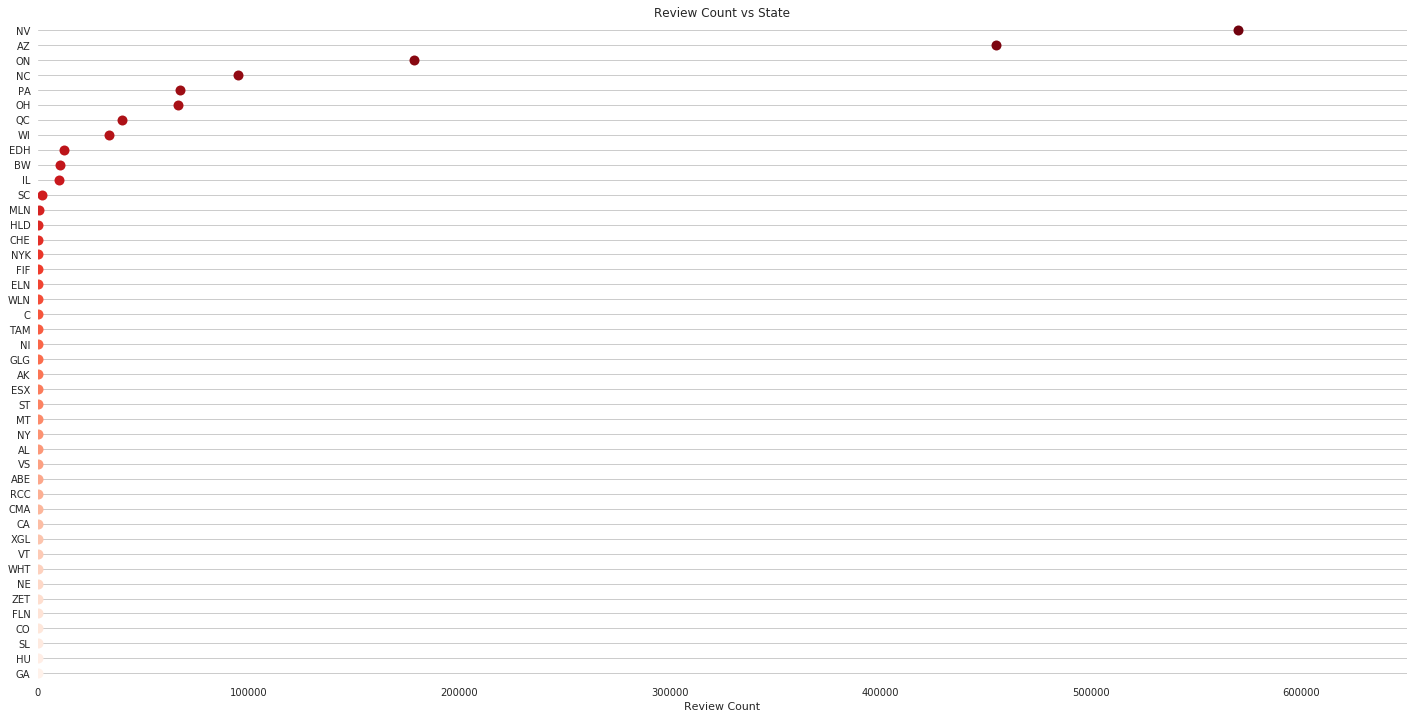

In [338]:
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(dd.sort_values("review_count", ascending=False),
                 x_vars='review_count', y_vars='state',
                 size=10, aspect=2)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-1, 650000), xlabel="Review Count", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Review Count vs State"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.show()

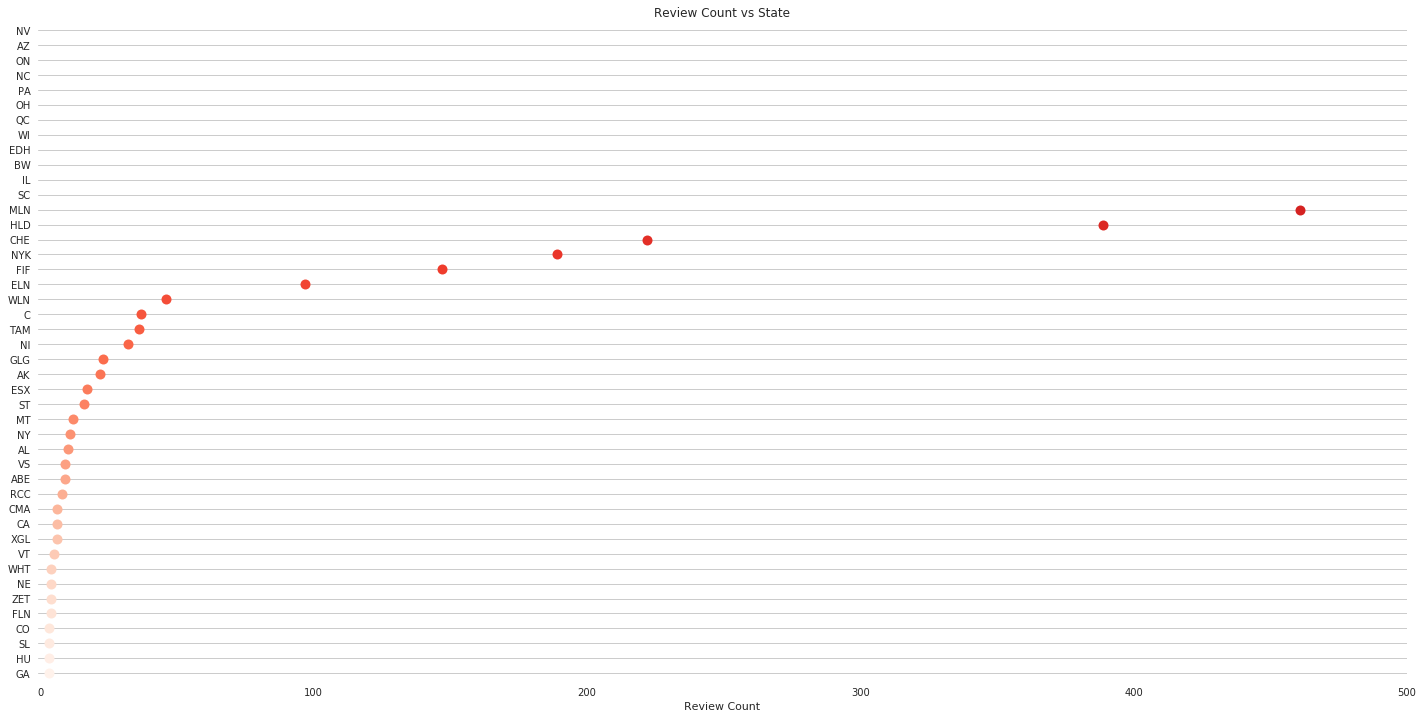

In [421]:
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(dd.sort_values("review_count", ascending=False),
                 x_vars='review_count', y_vars='state',
                 size=10, aspect=2)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-1, 500), xlabel="Review Count", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Review Count vs State"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.show()

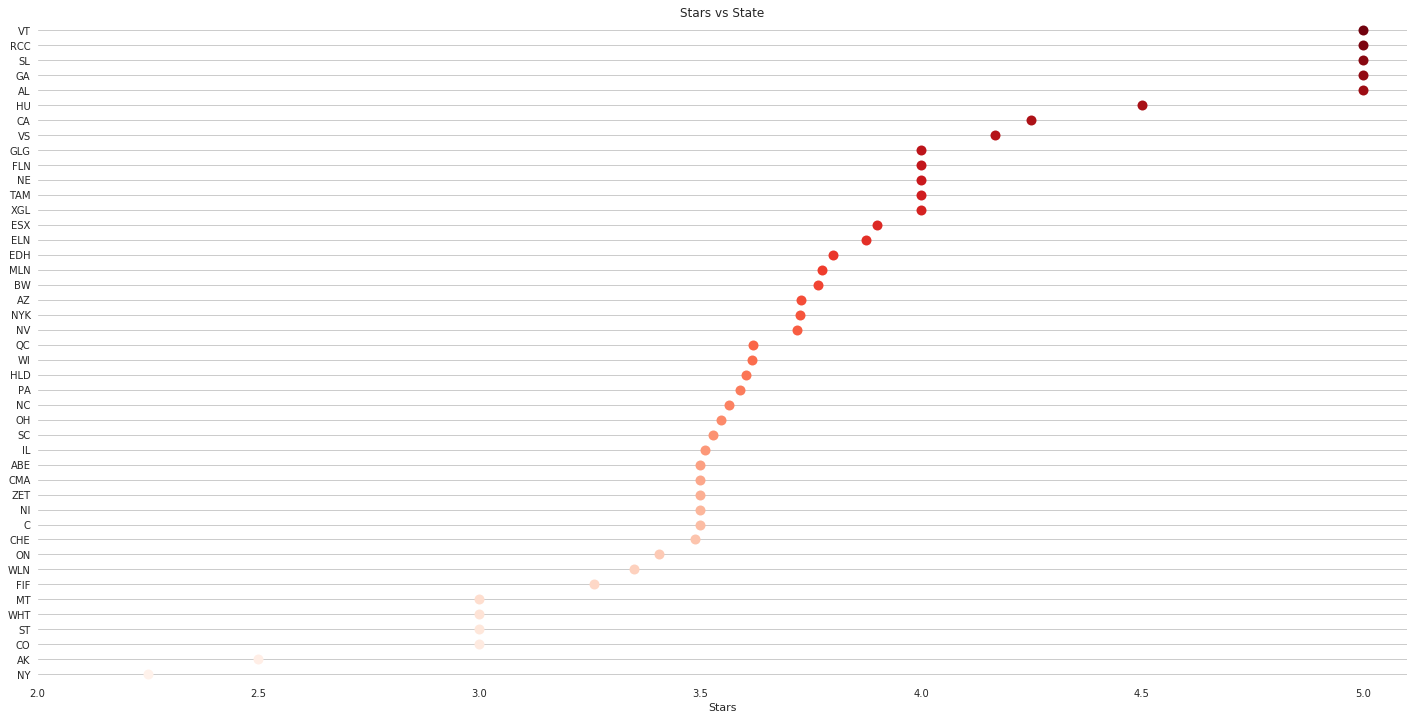

In [417]:
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(d.sort_values("stars", ascending=False),
                 x_vars='stars', y_vars='state',
                 size=10, aspect=2)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(2, 5.1), xlabel="Stars", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Stars vs State"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.show()

In [238]:
X = createClusterData(focused_sample['latitude'], focused_sample['longitude'], focused_sample['stars'])

In [239]:
clusters = cluster(X, 3, True)
centroids = clusters[0]

In [24]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(focused_sample['latitude'], focused_sample['longitude'], focused_sample['stars'])
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker="x", s=100)
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

In [25]:
b_samp1 = businessSampler.getOrderedSample(100000)
u_samp1 = userSampler.getOrderedSample(100000)
r_samp1 = reviewSampler.getOrderedSample(100000)

In [26]:
b_samp1.head()

,business_id,name,state,latitude,longitude,stars,review_count,is_open
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",AZ,33.330690,-111.978599,4.0,22,1
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",PA,40.291685,-80.104900,3.0,11,1
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",AZ,33.524903,-112.115310,1.5,18,1
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",AZ,33.383147,-111.964725,3.0,9,0
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",OH,41.119535,-81.475690,3.5,116,1


In [27]:
u_samp1.head()

,user_id,name,review_count,average_stars
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,3.70
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2.00
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,4.67
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,4.67
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,3.45


In [28]:
r_samp1.head()

,review_id,user_id,business_id,stars,date
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28


In [29]:
df1 = mergeWrapper(b_samp1, r_samp1, 'business_id')

In [30]:
df1.head()
print(len(df1))
print(len(u_samp1))

56864
100000


In [31]:
df = mergeWrapper(df1, u_samp1.head(56864), 'user_id')

In [32]:
df.head()

,business_id,name_x,state,latitude,longitude,stars_x,review_count_x,is_open,review_id,user_id,stars_y,date,name_y,review_count_y,average_stars
0,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",PA,40.291685,-80.104900,3.0,11,1,eBzyNuX1JdAXvSuMfY-W3A,g2vEmYXXwCh1325OVWNlIg,1,2016-07-25,Mary,3,2.33
1,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",AZ,33.524903,-112.115310,1.5,18,1,gBJz4sIjENjFSg5Jr4Tn3g,AYP5xC9BbbPh6OykFIvdJw,1,2017-03-31,Bryan,3,1.00
2,2qiwkbBeljR4KfwiwxAc4A,"""Champs Auto Repair Service""",AZ,33.582376,-112.171712,3.0,14,1,r3SWa_7rF7d5EUA9-BUJnw,AYP5xC9BbbPh6OykFIvdJw,1,2016-09-01,Bryan,3,1.00
3,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",OH,41.119535,-81.475690,3.5,116,1,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,Michelle,13,3.85
4,RFCRXj_SU_2yKoJYKIIywA,"""Pancho & Lefty's""",OH,41.158008,-81.443565,3.5,40,1,lqDBrJmaSChCyhynnZ_4dQ,bgtr7jOlALe8ay4g7pnf4A,4,2016-02-28,Michelle,13,3.85


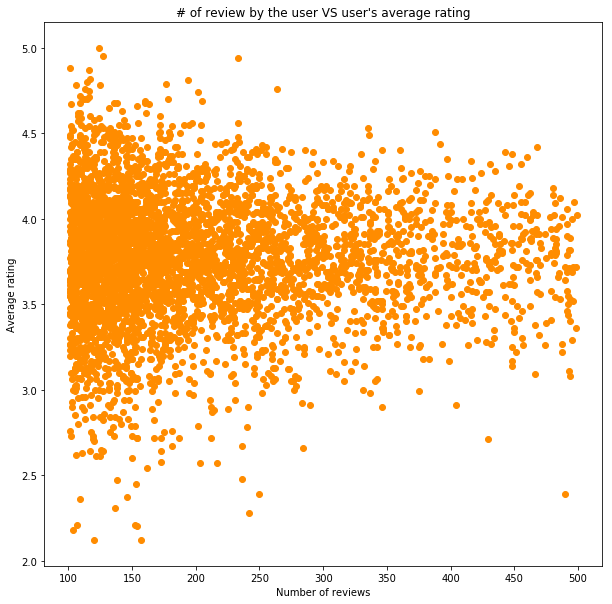

In [40]:
u_s = u_samp1[(u_samp1['review_count'] < 500) & (u_samp1['review_count'] > 100)]
plt.figure(figsize=(10,10))
plt.scatter(u_s['review_count'], u_s['average_stars'],color="darkorange")
plt.xlabel('Number of reviews')
plt.ylabel('Average rating')
plt.title('# of review by the user VS user\'s average rating')
plt.show()

In [48]:
stars = u_s['review_count']
is_open = u_s['average_stars']
data = pd.concat([stars, is_open], axis=1)
pal = dict(stars="purple",is_open="grey")
sns.jointplot(x="review_count", y="average_stars",data=data);

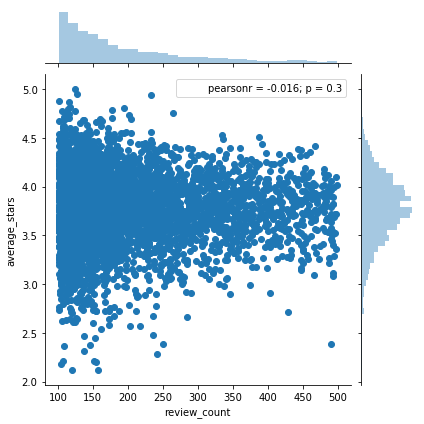

In [42]:
plt.show()

# The Pearson Product-Moment Correlation Coefficient
`pearsonr` is a linear correlation coefficient, clearly uncorrelated.

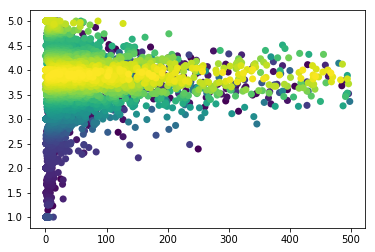

In [54]:

# Generate fake data
x = u_samp1[u_samp1['review_count'] < 500]['review_count'].head(10000)
y = u_samp1[u_samp1['average_stars'] < 500]['average_stars'].head(10000)

# Calculate the point density
xy = np.vstack([x,y])
z = sc.gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()

In [175]:
u_samp = userSampler.getRandomSample(100000)
b_samp = businessSampler.getRandomSample(100000)
r_samp = reviewSampler.getRandomSample(100000)
u_samp.head()

,user_id,name,review_count,average_stars
41938,pPY8XfQ99YviEM6lDchhrg,Courtney,15,4.27
411476,rMxM9BqIubunRI6zAw3v_Q,Stacy,19,4.47
5467,xMDxdS_eZG-i8bTD_se5zA,Kshitij,2,5.00
18582,IZWkc2MIz3lBSY4X4Y_X3A,Martha,1,1.00
211839,QyyCQb7i4YHZeHLPeLfYLQ,Ashley,102,3.78


In [176]:
b_samp.head()

,business_id,name,latitude,longitude,stars,review_count,is_open
3384,KUxhgOP_NdAalHwPp0xN0A,"""My Laundry Room""",33.467823,-112.029639,2.5,5,0
163844,S2uJ9AWcoI7toQRVwohkBA,"""Katie's Clay Studio""",40.555427,-79.957548,4.5,3,1
57653,GXix-iwZYUqTPOlw_2Hvbw,"""Herig Eye Institute""",43.669314,-79.393574,3.5,3,1
71220,OZ9tVs7c5blngLkoovh5YQ,"""VaporIce""",33.597019,-112.036218,2.5,16,1
6126,yVAsYV9p1B6TJXNXOL9KSQ,"""Longo's""",43.488352,-79.717775,4.0,7,1


In [177]:
r_samp.head()

,review_id,user_id,business_id,stars,date
484225,HUiVn2lRJACFvgFpLXBDXw,ZNvSWTAsKbu9wKz7WCUnyw,700A-sisAtKIqGEcR7gASg,1,2014-05-19
25300,GgLUMCaKEouiRyapyA3-XA,Nvl8U2rJGwCeHk9q3Y8UlA,1uCoWygbmehTJP8Su_3QVA,1,2014-06-08
257051,hq6U1qxa10OSoXZwoSeWGw,WlM65dJAhHMf9N5ZQqGQ2w,rbywwnfMjFjJwLQkgpdIEw,5,2013-05-03
258740,UI0qqYF2zq-q4khJ5ioRlQ,epX4X5X_7JYIa8u7FAr2iA,83cVpTJNyzv9lJ20vzBgdg,5,2017-01-19
168195,P6bdB_by27w6heFkbZDh4g,k8TxDsIiNbW6b04_hd5zEg,8KmqWgL0UEdxJFwTZ_YZvQ,4,2011-05-29


In [178]:
u_samp = u_samp[['review_count', 'average_stars', 'user_id']]
b_samp = b_samp[['business_id', 'review_count', 'is_open']]
r_samp = r_samp[['user_id','business_id','stars']]
u_samp.head()

,review_count,average_stars,user_id
41938,15,4.27,pPY8XfQ99YviEM6lDchhrg
411476,19,4.47,rMxM9BqIubunRI6zAw3v_Q
5467,2,5.00,xMDxdS_eZG-i8bTD_se5zA
18582,1,1.00,IZWkc2MIz3lBSY4X4Y_X3A
211839,102,3.78,QyyCQb7i4YHZeHLPeLfYLQ


In [179]:
df = mergeWrapper(u_samp, r_samp, 'user_id')
len(df)

20299

In [181]:
df = mergeWrapper(df, b_samp.head(20299), 'business_id')

In [182]:
df.head(10)

,review_count_x,average_stars,user_id,business_id,stars,review_count_y,is_open
0,15,4.27,pPY8XfQ99YviEM6lDchhrg,Jd-XHSl0t0JWotORH0IsSg,1,55,1
1,211,2.94,65Bcz8_Rbbrcz_HGpq9Y-g,Jd-XHSl0t0JWotORH0IsSg,1,55,1
2,10,4.30,xMc_GR2LIQ7o_DVyEAKGLQ,3HmrkEZQWaemS2aPoe-xJA,1,114,0
3,10,4.30,xMc_GR2LIQ7o_DVyEAKGLQ,3HmrkEZQWaemS2aPoe-xJA,1,114,0
4,57,3.32,X4FlbqinfezlvhLFSZoeXA,cejOLn5kPuVgm3TMLnpWlQ,5,50,1
5,211,3.96,eZZUxt0aNMTg0di_hLBzbA,PBmfdx-tC2D54FI3HtcKww,3,63,1
6,1,1.00,EUdZFZfsmunRKiDbD-rDpQ,tTyFInKm8AY0cY5ujtXZHA,1,50,1
7,3,3.00,elO-P5qSQmuQ22vEoTfW8A,tTyFInKm8AY0cY5ujtXZHA,5,50,1
8,3,5.00,UL16SJSpUMImbPf9rTs5Zw,ozEDKl0tZw5ob1evx41gcQ,5,381,1
9,23,3.57,PetJU8HLwj0A-VVzvGYblA,ozEDKl0tZw5ob1evx41gcQ,4,381,1


In [183]:
b_samp = b_samp[b_samp['review_count'] < 500]
stars = b_samp['review_count'].head(1000)
is_open = b_samp['is_open'].head(1000)
data = pd.concat([stars, is_open], axis=1)
sns.regplot(x='review_count', y='is_open', data=data, logistic=True)

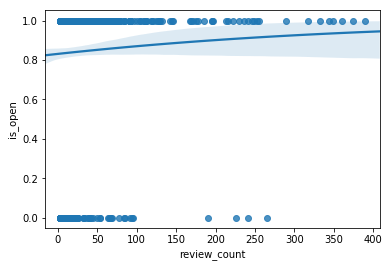

In [184]:
plt.show()

We can see that the majority of our data points are open businesses.

In [185]:
df = df[df['review_count_y'] < 2000]
plt.scatter(df['review_count_y'], df['stars'])

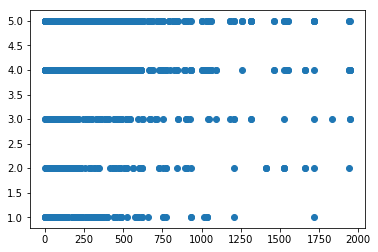

In [186]:
plt.show()

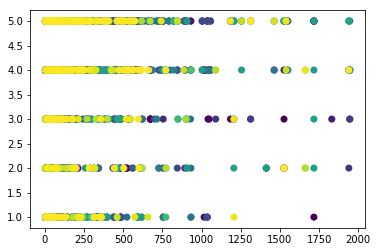

In [203]:
densityWrapper(df['review_count_y'], df['stars'])